In [1]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
from rasterio.enums import Resampling


In [46]:


# Open both rasters
with rasterio.open("/shared_space/ACV/clipped_labeled_nlcd_nc0.1.tif") as src1:
    nlcd_data = src1.read(1)  # Read the first band
    metadata = src1.meta  # Get the metadata of the first raster

# Open the second raster
with rasterio.open("clipped_output_file.tif") as src2:
    output_data = src2.read(1)  # Read the first band

    # Resample the second raster to match the first one
    output_resampled = src2.read(
        1,
        out_shape=(src1.count, nlcd_data.shape[0], nlcd_data.shape[1]),
        resampling=Resampling.nearest  # Use nearest neighbor for resampling
    )

# Now you can compare the resampled output_data with nlcd_data
condition_nlcd = np.isin(nlcd_data, [21, 22, 23, 24]) #urban Land type [21, 22, 23, 24]
condition_output = output_resampled > 38 #wind speed of atleast 20m/s

# Combine the conditions to find the overlap
result = condition_nlcd & condition_output

# Create a new output file to save the result
output_path = "combined_result_ub_40.tif"

# Get the metadata from the first raster to maintain the same shape and georeferencing
with rasterio.open("/shared_space/ACV/nlcd_nc0.1.tif") as src1:
    metadata = src1.meta

# Update the metadata to store boolean values (0 or 1) for the result
metadata.update(dtype=rasterio.uint8, count=1)

# Write the result to the new file
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(result.astype(rasterio.uint8), 1)

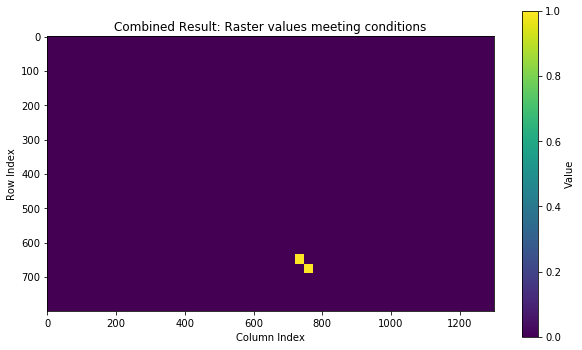

In [47]:
# Open the combined_result.tif file
with rasterio.open("combined_result_ub_40.tif") as src:
    combined_result_data = src.read(1)  # Read the first band (the result)
    metadata = src.meta  # Get metadata for the raster (for axis and georeferencing)
# Plot the combined result
plt.figure(figsize=(10, 6))
plt.imshow(combined_result_data, cmap='viridis', interpolation='none')
plt.colorbar(label='Value')
plt.title('Combined Result: Raster values meeting conditions')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [40]:
import rasterio

# Output file path
output_path = "combined_result_ub_35.tif"

# Use the metadata from the original raster (which includes georeferencing information)
with rasterio.open("/shared_space/ACV/clipped_labeled_nlcd_nc0.1.tif") as src1:
    metadata = src1.meta  # Get the metadata from the first raster
    
    # Update the metadata for saving (use uint8 for the result as it's binary)
    metadata.update(dtype=rasterio.uint8, count=1)

# Write the result to the new GeoTIFF file
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(result.astype(rasterio.uint8), 1)


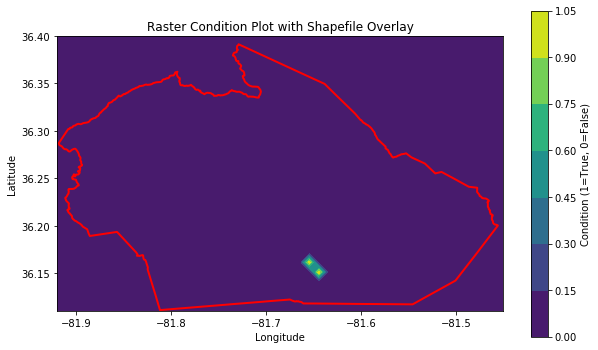

In [41]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import cartopy
#import geodatasets
import contextily as cx

# Open the saved raster file
with rasterio.open(output_path) as src:
    # Read the data from the first band
    result_data = src.read(1)
    
    # Get the transformation (to convert pixel coordinates to geographic coordinates)
    transform = src.transform
    
    # Get the number of rows and columns
    nrows, ncols = result_data.shape  # Correct the order here

    # Create the longitude and latitude arrays based on the transformation
    lon = np.linspace(transform[2], transform[2] + transform[0] * ncols, ncols)
    lat = np.linspace(transform[5], transform[5] + transform[4] * nrows, nrows)
    
    # Create a meshgrid for the coordinates (lat, lon)
    lon, lat = np.meshgrid(lon, lat)  # Ensure lat and lon are correctly oriented

# Plot the raster data
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, result_data, cmap='viridis') #alpha = 0.4
plt.colorbar(label='Condition (1=True, 0=False)')

# Load the shapefile using geopandas
gdf = gpd.read_file("filtered_watauga.shp")

# Plot the shapefile on top of the raster
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=2)
# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Raster Condition Plot with Shapefile Overlay')

# Show the plot
plt.show()





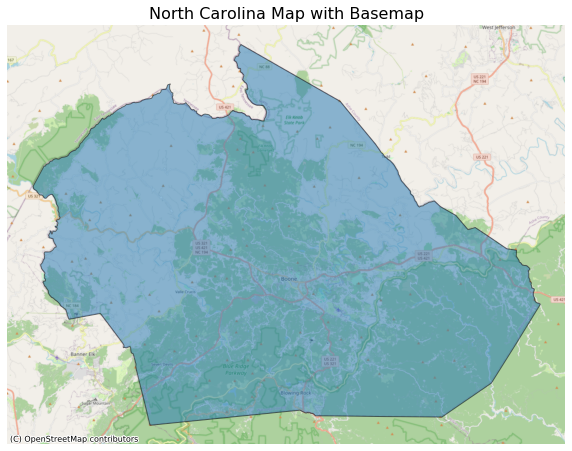

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

# Load the shapefile
shapefile_path = 'filtered_watauga.shp'
nc_counties = gpd.read_file(shapefile_path)

# Check the CRS and reproject to Web Mercator if necessary
if isinstance(nc_counties.crs, dict):
    # Extract EPSG if `crs` is a dict
    current_epsg = nc_counties.crs.get('init', '').split(':')[-1]
else:
    current_epsg = nc_counties.crs.to_epsg()

if current_epsg != '3857':
    nc_counties = nc_counties.to_crs(epsg=3857)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
nc_counties.plot(ax=ax, alpha=0.5, edgecolor='k')  # Plot shapefile with some transparency

# Add basemap
cx.add_basemap(ax, crs=nc_counties.crs, source=cx.providers.OpenStreetMap.Mapnik)

# Finalize plot
ax.set_title('North Carolina Map with Basemap', fontsize=16)
ax.axis('off')  # Turn off axes for a cleaner map
plt.show()





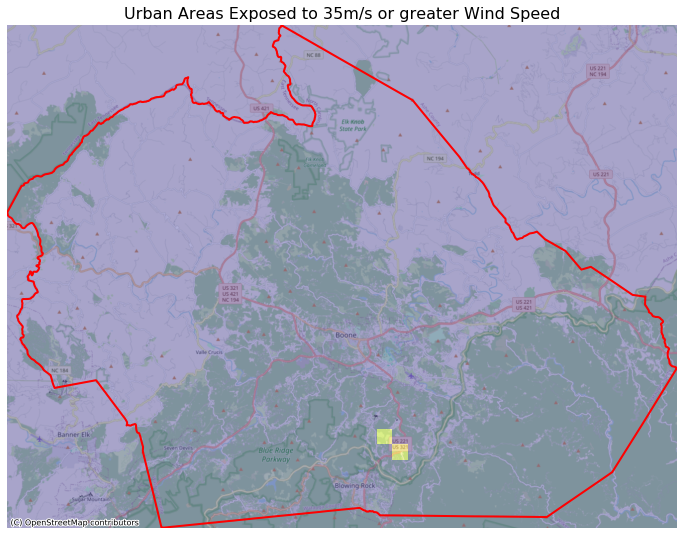

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Paths to input files
shapefile_path = "filtered_watauga.shp"
raster_path = "combined_result_ub_35.tif"

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Reproject shapefile to Web Mercator (EPSG:3857) for compatibility with basemap
if isinstance(gdf.crs, dict):
    current_epsg = gdf.crs.get('init', '').split(':')[-1]
else:
    current_epsg = gdf.crs.to_epsg()

if current_epsg != '3857':
    gdf = gdf.to_crs(epsg=3857)

# Load the raster file
with rasterio.open(raster_path) as src:
    # Reproject raster to Web Mercator (EPSG:3857) if necessary
    if src.crs.to_epsg() != 3857:
        transform, width, height = calculate_default_transform(
            src.crs, 'EPSG:3857', src.width, src.height, *src.bounds
        )
        reprojected_raster = np.empty((height, width), dtype=src.meta['dtype'])
        reproject(
            source=rasterio.band(src, 1),
            destination=reprojected_raster,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs='EPSG:3857',
            resampling=Resampling.nearest,
        )
        raster_data = reprojected_raster
        raster_transform = transform
    else:
        raster_data = src.read(1)
        raster_transform = src.transform

    # Mask no-data values (assuming no-data value is 0 or can be derived from src.nodata)
    raster_data = np.ma.masked_equal(raster_data, src.nodata) if src.nodata is not None else raster_data

    # Get raster bounds
    raster_bounds = rasterio.transform.array_bounds(
        raster_data.shape[0], raster_data.shape[1], raster_transform
    )

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the raster
extent = [raster_bounds[0], raster_bounds[2], raster_bounds[1], raster_bounds[3]]
ax.imshow(raster_data, extent=extent, cmap='plasma', alpha=0.8, origin='upper')

# Plot the shapefile
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Zoom in on the shapefile bounds
xlim = (gdf.total_bounds[0], gdf.total_bounds[2])  # MinX, MaxX
ylim = (gdf.total_bounds[1], gdf.total_bounds[3])  # MinY, MaxY
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Add the basemap with transparency
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, alpha=0.6)

# Finalize plot
ax.set_title("Urban Areas Exposed to 35m/s or greater Wind Speed", fontsize=16)
ax.axis('off')

# Show the plot
plt.show()
